In [1]:
import os
import shutil
import pandas as pd

In [2]:
skin_cancer = 'dataset/Skin_Cancer_Dataset'
norm_skin = 'dataset/norm'
results = 'dataset/result'

os.makedirs(results, exist_ok=True)

labels = ['Basal Cell Carcinoma','Melanoma', 'Squamous Cell Carcinoma', 'Normal']
for label in labels:
  os.makedirs(os.path.join(results, label), exist_ok=True)

for label in labels[:-1]:
  label_path = os.path.join(skin_cancer, label)
  if os.path.exists(label_path):
    for file in os.listdir(label_path):
      shutil.copy(os.path.join(label_path, file), os.path.join(results, label))

for file in os.listdir(norm_skin):
  shutil.copy(os.path.join(norm_skin, file), os.path.join(results, 'Normal'))

In [3]:
from PIL import Image

def clean_data(directory):
  for label in os.listdir(directory):
    label_path = os.path.join(directory, label)
    if file in os.listdir(label_path):
      file_path = os.path.join(label_path, file)
      try:
        img = Image.open(file_path)
        img.verify()
        img = Image.open(file_path)
        img.load()
      except Exception as e:
        print(f"Delete: {file_path}, Error: {e}")
        os.remove(file_path)

clean_data(results)

                     class  count
0     Basal Cell Carcinoma    500
1                 Melanoma    505
2                   Normal    124
3  Squamous Cell Carcinoma    414


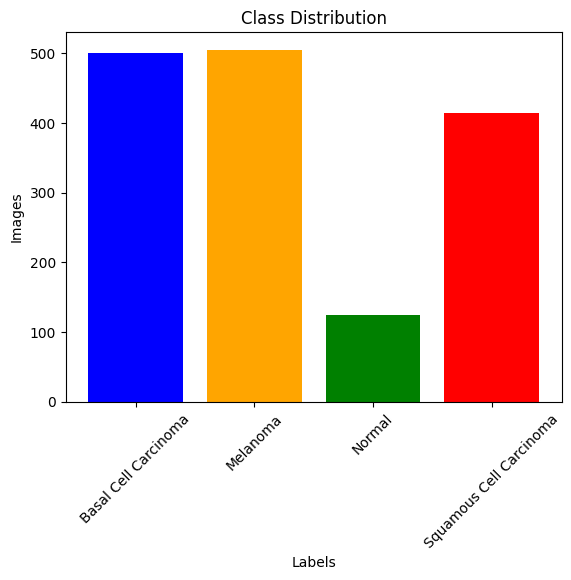

In [4]:
import matplotlib.pyplot as plt

def distribution_data(directory):
  count = {}
  for label in os.listdir(directory):
    label_path = os.path.join(directory, label)
    count[label] = len(os.listdir(label_path))
  return count

class_distribution = distribution_data(results)

# DataFrame distributions
df = pd.DataFrame(list(class_distribution.items()), columns=['class', 'count'])
print(df)

plt.bar(class_distribution.keys(), class_distribution.values(),
        color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Labels')
plt.ylabel('Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

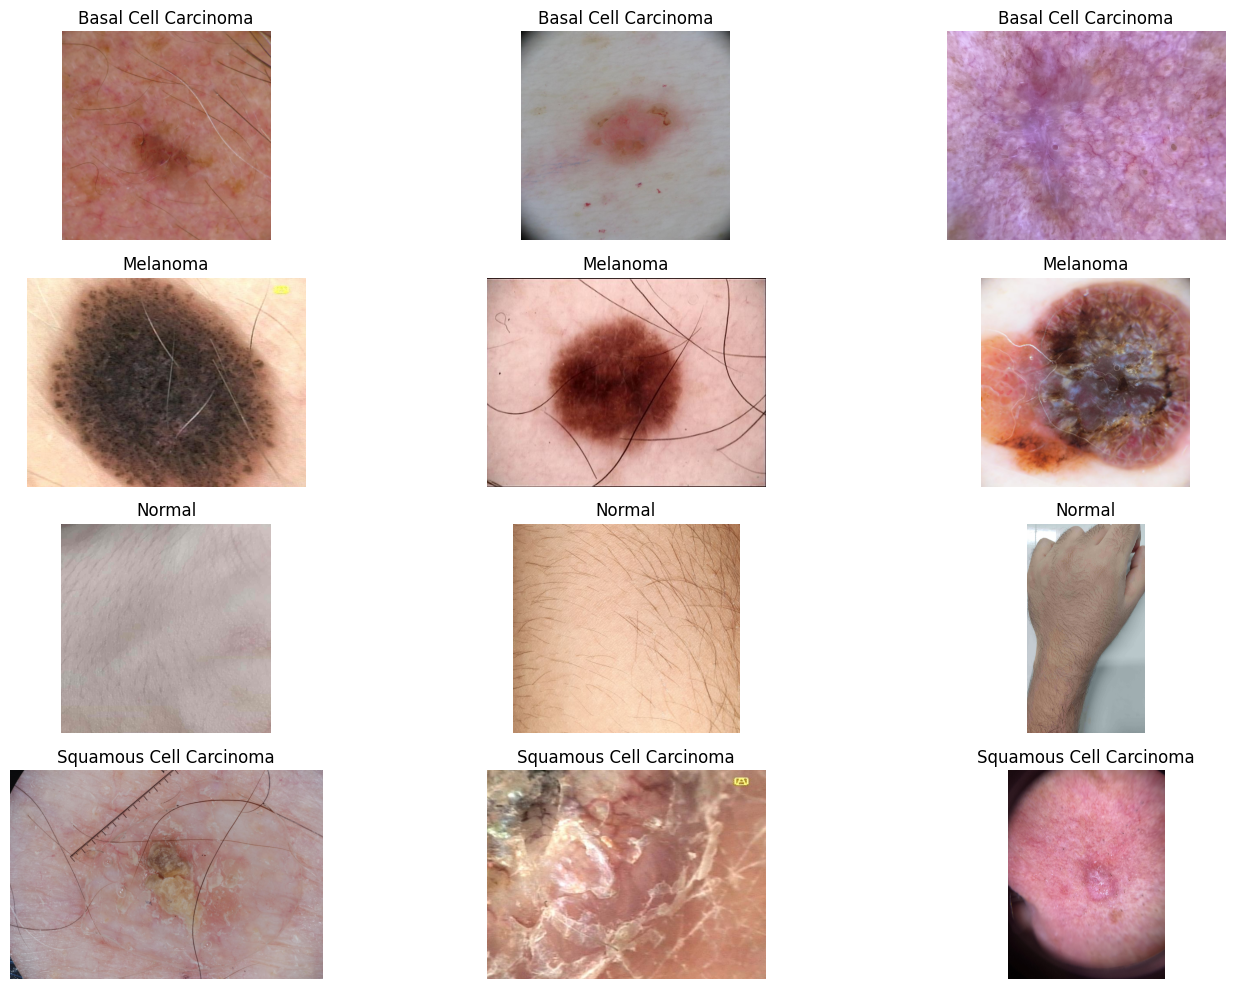

In [5]:
import random

# Visualisasi sampel gambar
def plot_sample_images(directory, classes, num_samples=3):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))
    for i, cls in enumerate(classes):
        cls_path = os.path.join(directory, cls)
        samples = random.sample(os.listdir(cls_path), num_samples)
        for j, sample in enumerate(samples):
            img_path = os.path.join(cls_path, sample)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(cls)
    plt.tight_layout()
    plt.show()


plot_sample_images(results, list(class_distribution.keys()))

In [6]:
# import numpy as np

# # Preprocess gambar
# def preprocess_images(directory, target_size=(224, 224)):
#     processed_data = []
#     labels = []
#     class_mapping = {cls: i for i, cls in enumerate(os.listdir(directory))}

#     for cls in os.listdir(directory):
#         cls_path = os.path.join(directory, cls)
#         for file in os.listdir(cls_path):
#             file_path = os.path.join(cls_path, file)
#             try:
#                 img = Image.open(file_path).resize(target_size)
#                 img_array = np.array(img) / 255.0  # Normalisasi
#                 processed_data.append(img_array)
#                 labels.append(class_mapping[cls])
#             except Exception as e:
#                 print(f"Error processing {file_path}: {e}")
#     return np.array(processed_data), np.array(labels)


# # Preprocess dataset
# X, y = preprocess_images(results)
# print(f"Processed data shape: {X.shape}, Labels shape: {y.shape}")

In [7]:
from sklearn.model_selection import train_test_split


def split_data(source, destination, split_ratio, labels):
  train = os.path.join(destination, 'train')
  val = os.path.join(destination, 'val')
  test =  os.path.join(destination, 'test')

  os.makedirs(train, exist_ok=True)
  os.makedirs(val, exist_ok=True)
  os.makedirs(test, exist_ok=True)

  for label in labels:
    label_path = os.path.join(source, label)
    files = os.listdir(label_path)

    # splitt 
    train_files, temp_files = train_test_split(files, test_size=(1 - split_ratios[0]), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(split_ratios[2] / sum(split_ratios[1:])), random_state=42)

    # Pindahkan file ke folder baru
    for phase, phase_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        phase_dir = os.path.join(destination, phase, label)
        os.makedirs(phase_dir, exist_ok=True)
        for file in phase_files:
            shutil.copy(os.path.join(label_path, file), os.path.join(phase_dir, file))

# Path split data
split_ratios = [0.7, 0.2, 0.1]  # Train, Validation, Test
split_data(results, './dataset/split', split_ratios, labels)

## Aug

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Data generator
train_gen = train_datagen.flow_from_directory(
    './dataset/split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    './dataset/split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    './dataset/split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1077 images belonging to 4 classes.
Found 309 images belonging to 4 classes.
Found 157 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load arsitektur EfficientNetB0
base_model = EfficientNetB0(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Tambahkan layer custom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(train_gen, validation_data=val_gen, epochs=15)

In [ ]:
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Ekstraksi fitur HOG
def extract_hog_features(image_dir):
    data, labels = [], []
    for cls in labels:
        cls_dir = os.path.join(image_dir, cls)
        for file in os.listdir(cls_dir):
            img = cv2.imread(os.path.join(cls_dir, file), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            hog = cv2.HOGDescriptor()
            h = hog.compute(img).flatten()
            data.append(h)
            labels.append(cls)
    return data, labels


# Ekstraksi fitur
train_data, train_labels = extract_hog_features('./dataset/split/train')
test_data, test_labels = extract_hog_features('./dataset/split/test')

# Train Random Forest
rf = RandomForestClassifier()
rf.fit(train_data, train_labels)

# Evaluate
preds = rf.predict(test_data)
print(classification_report(test_labels, preds))

In [ ]:
# Plot evaluasi
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.2f}")